In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2, pathlib

# load the trained model
model = keras.models.load_model("../models/baseline_cnn.keras")

# choose one test image
DATA_DIR = pathlib.Path("../data/test/COVID")
img_path = list(DATA_DIR.glob("*.png"))[0]   # pick first image
img = keras.utils.load_img(img_path, target_size=(128, 128))
img_array = keras.utils.img_to_array(img)[None, ...] / 255.0

# predict class
pred = model.predict(img_array)[0][0]
label = "COVID" if pred < 0.5 else "NORMAL"
print(f"Predicted: {label}  (prob={pred:.3f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Predicted: COVID  (prob=0.477)


Loaded image: ..\data\test\COVID\COVID-2001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted: COVID  (prob=0.477)
Last conv layer: conv2d_2


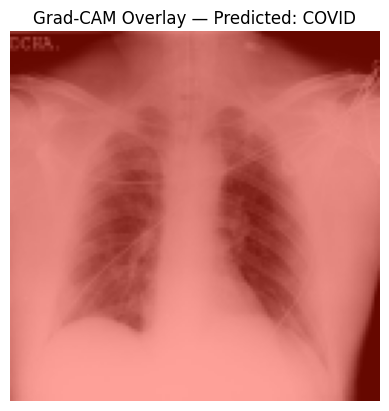

✅ Saved Grad-CAM image to: ../images/gradcam_example.png


In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2, pathlib

# 1️⃣ Load your trained model
model = keras.models.load_model("../models/baseline_cnn.keras")

# 2️⃣ Pick one test image
DATA_DIR = pathlib.Path("../data/test/COVID")
# If your images are .png
img_path = list(DATA_DIR.glob("*.png"))[0]
print("Loaded image:", img_path)

# Prepare image for model
img = keras.utils.load_img(img_path, target_size=(128, 128))
img_array = keras.utils.img_to_array(img)[None, ...] / 255.0

# Make a prediction
pred = model.predict(img_array)[0][0]
label = "COVID" if pred < 0.5 else "NORMAL"
print(f"Predicted: {label}  (prob={pred:.3f})")

# 3️⃣ Grad-CAM heatmap function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:, 0]  # binary output
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap

# 4️⃣ Find the last convolutional layer
last_conv_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_name = layer.name
        break
print("Last conv layer:", last_conv_name)

# 5️⃣ Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_name)

# 6️⃣ Overlay the heatmap on the original image
img_orig = cv2.imread(str(img_path))
img_orig = cv2.resize(img_orig, (128, 128))
hm = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
hm = np.uint8(255 * hm)
hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_orig, 0.6, hm, 0.4, 0)

# 7️⃣ Save & display
pathlib.Path("../images").mkdir(exist_ok=True)
out_path = "../images/gradcam_example.png"
cv2.imwrite(out_path, overlay)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Overlay — Predicted: {label}")
plt.axis("off")
plt.show()

print("✅ Saved Grad-CAM image to:", out_path)
